In [21]:
!pip install tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

%matplotlib inline

import pandas as pd

data = pd.read_csv('https://drive.google.com/uc?authuser=0&id=12Jd3D_o66vQFnwuSep4KZY8OGSIwc9kn&export=download')
print(f'Всего данных: {data.shape[0]}')
data.head()


Всего данных: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
data=data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [0]:


class FillNa(TransformerMixin, BaseEstimator):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    def fit(self, X: pd.DataFrame, y=None):
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()
class PandasToNumpy(BaseEstimator):
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
class SparseToArray(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()
class ModifyLabelEncoder(preprocessing.LabelEncoder):
    def fit(self, X, y=None):
        return super().fit(X)
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
class ExpandDims(TransformerMixin, BaseEstimator):
    def __init__(self, axis):
        self.axis = axis
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)   

In [24]:
data.iloc[:,1:8].isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [26]:
X_data = data.iloc[:,1:8].copy()
X_data = pd.get_dummies(X_data)
Y_data = data[data.columns[0]].copy()

fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(821, 8) (821, 821)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [27]:
number_data_ready_X[:10,:], number_data_ready_Y[::40]

(array([[0.        , 1.        , 0.37002318, 0.33333333, 0.        ,
         0.04397492, 0.        , 1.        ],
        [1.        , 0.        , 0.5638622 , 0.33333333, 0.        ,
         0.4323693 , 1.        , 0.        ],
        [1.        , 1.        , 0.41848293, 0.        , 0.        ,
         0.04806914, 1.        , 0.        ],
        [1.        , 0.        , 0.52751738, 0.33333333, 0.        ,
         0.32207838, 1.        , 0.        ],
        [0.        , 1.        , 0.52751738, 0.        , 0.        ,
         0.04882733, 0.        , 1.        ],
        [0.        , 1.        , 0.80908601, 0.        , 0.        ,
         0.05130387, 0.        , 1.        ],
        [0.        , 0.        , 0.75770122, 0.        , 0.        ,
         0.31457232, 0.        , 1.        ],
        [0.        , 1.        , 0.1277244 , 1.        , 0.5       ,
         0.12783054, 0.        , 1.        ],
        [1.        , 1.        , 0.43059787, 0.        , 1.        ,
         0.

In [28]:
import sys
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((821, 8), (821, 821))

In [0]:

model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
model.add(Dense(Y_train.shape[1], activation=activations.softmax))
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

In [30]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 1s - loss: 6.7748 - categorical_accuracy: 0.0000e+00
Epoch 2/100
 - 0s - loss: 6.6559 - categorical_accuracy: 0.0037
Epoch 3/100
 - 0s - loss: 6.4366 - categorical_accuracy: 0.0037
Epoch 4/100
 - 0s - loss: 6.1611 - categorical_accuracy: 0.0061
Epoch 5/100
 - 0s - loss: 5.8835 - categorical_accuracy: 0.0085
Epoch 6/100
 - 0s - loss: 5.6413 - categorical_accuracy: 0.0122
Epoch 7/100
 - 0s - loss: 5.4371 - categorical_accuracy: 0.0207
Epoch 8/100
 - 0s - loss: 5.2612 - categorical_accuracy: 0.0219
Epoch 9/100
 - 0s - loss: 5.1040 - categorical_accuracy: 0.0244
Epoch 10/100
 - 0s - loss: 4.9636 - categorical_accuracy: 0.0365
Epoch 11/100
 - 0s - loss: 4.8368 - categorical_accuracy: 0.0390
Epoch 12/100
 - 0s - loss: 4.7225 - categorical_accuracy: 0.0451
Epoch 13/100
 - 0s - loss: 4.6197 - categorical_accuracy: 0.0414
Epoch 14/100
 - 0s - loss: 4.5256 - categorical_accuracy: 0.0560
Epoch 15/100
 - 0s - loss: 4.4415 - categorical_accuracy: 0.0597
Epoch 16/100
 - 0s - loss: 4.3

In [31]:
model.evaluate(X_train, Y_train)

821/821 [==============================] - 0s 72us/step


[2.517220790435568, 0.37515225345847375]

In [32]:
from keras import callbacks


XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
#Выводим информацию 
print("Всего данных: {Z}".format(Z=XY_data.shape[0]))
print("Тренировочных данных: {Z}".format(Z=train_data.shape[0]))
print("Тестовых данных: {Z}".format(Z=test_data.shape[0]))
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, :number_data_ready_Y.shape[1] ]
print("Размер данные для тренировки (входных): {Z}".format(Z=X_train.shape))
print("Размер данные для тренировки (выходных): {Z}".format(Z=Y_train.shape))

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, :number_data_ready_Y.shape[1] ]
print('Размер данные для теста (входных): {Z}'.format(Z=X_test.shape))
print('Размер данные для теста (выходных): {Z}'.format(Z=Y_test.shape))

Всего данных: 821
Тренировочных данных: 657
Тестовых данных: 164
Размер данные для тренировки (входных): (657, 8)
Размер данные для тренировки (выходных): (657, 821)
Размер данные для теста (входных): (164, 8)
Размер данные для теста (выходных): (164, 821)


In [0]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [35]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]    
)

Начинаем обучение сети
Train on 657 samples, validate on 164 samples
Epoch 1/100
657/657 [==============================] - 0s 637us/step - loss: 22.6733 - categorical_accuracy: 0.1553 - val_loss: 16.4340 - val_categorical_accuracy: 0.2134
Epoch 2/100
657/657 [==============================] - 0s 396us/step - loss: 14.2346 - categorical_accuracy: 0.2009 - val_loss: 15.1888 - val_categorical_accuracy: 0.2500
Epoch 3/100
657/657 [==============================] - 0s 384us/step - loss: 13.5035 - categorical_accuracy: 0.2511 - val_loss: 15.4638 - val_categorical_accuracy: 0.2439
Epoch 4/100
657/657 [==============================] - 0s 384us/step - loss: 13.2326 - categorical_accuracy: 0.2359 - val_loss: 15.7593 - val_categorical_accuracy: 0.2988
Epoch 5/100
657/657 [==============================] - 0s 387us/step - loss: 13.0513 - categorical_accuracy: 0.2542 - val_loss: 16.0033 - val_categorical_accuracy: 0.2683
Epoch 6/100
657/657 [==============================] - 0s 412us/step - loss:

In [36]:
model.evaluate(X_train, Y_train)

657/657 [==============================] - 0s 45us/step


[9.592401417423057, 0.5966514465108491]

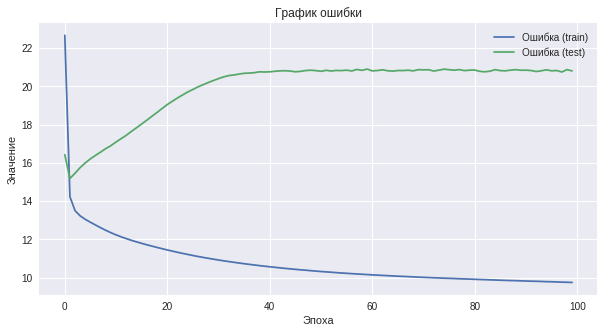

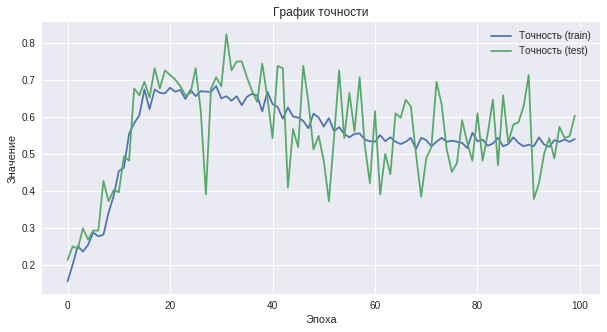

In [37]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [38]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/100
656/656 [==============================] - 0s 650us/step - loss: 6.7702 - categorical_accuracy: 0.0000e+00 - val_loss: 6.8483 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
656/656 [==============================] - 0s 429us/step - loss: 6.5205 - categorical_accuracy: 0.0015 - val_loss: 7.3022 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
656/656 [==============================] - 0s 426us/step - loss: 6.1285 - categorical_accuracy: 0.0030 - val_loss: 8.0824 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
656/656 [==============================] - 0s 437us/step - loss: 5.8118 - categorical_accuracy: 0.0046 - val_loss: 8.9078 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
656/656 [==============================] - 0s 421us/step - loss: 5.5580 - categorical_accuracy: 0.0076 - val_loss: 9.6840 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
656/656 [==============================] - 0s 413u

In [39]:
model.evaluate(number_data_ready_X, number_data_ready_Y)

821/821 [==============================] - 0s 50us/step


[5.205819309991983, 0.2984165651644336]

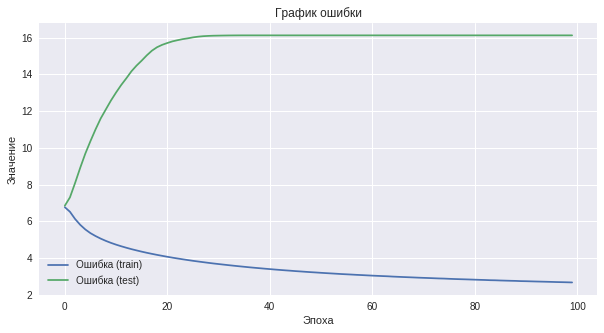

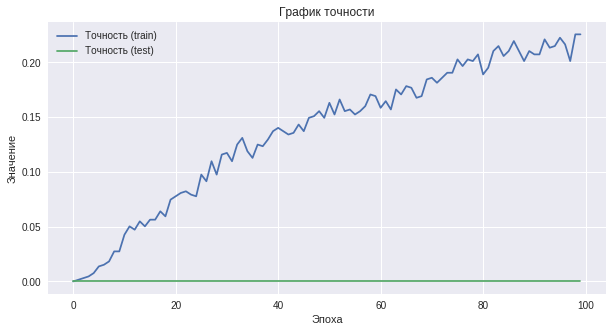

In [40]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [41]:
#улучшение сети - ранняя остановка 
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/300
656/656 [==============================] - 0s 758us/step - loss: 6.7701 - categorical_accuracy: 0.0000e+00 - val_loss: 6.8470 - val_categorical_accuracy: 0.0000e+00
Epoch 2/300
656/656 [==============================] - 0s 449us/step - loss: 6.5611 - categorical_accuracy: 0.0046 - val_loss: 7.3099 - val_categorical_accuracy: 0.0000e+00
Epoch 3/300
656/656 [==============================] - 0s 444us/step - loss: 6.1862 - categorical_accuracy: 0.0091 - val_loss: 8.1565 - val_categorical_accuracy: 0.0000e+00
Epoch 4/300
656/656 [==============================] - 0s 420us/step - loss: 5.8094 - categorical_accuracy: 0.0152 - val_loss: 9.0601 - val_categorical_accuracy: 0.0000e+00
Epoch 5/300
656/656 [==============================] - 0s 427us/step - loss: 5.5382 - categorical_accuracy: 0.0168 - val_loss: 9.8497 - val_categorical_accuracy: 0.0000e+00
Epoch 6/300
656/656 [==============================] - 0s 411u

In [42]:
model.evaluate(number_data_ready_X, number_data_ready_Y)

821/821 [==============================] - 0s 47us/step


[5.6545501039902275, 0.24116930572472595]

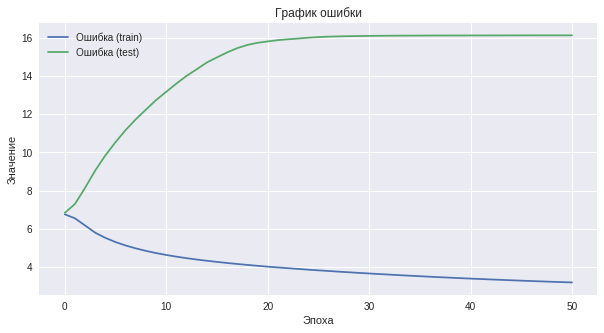

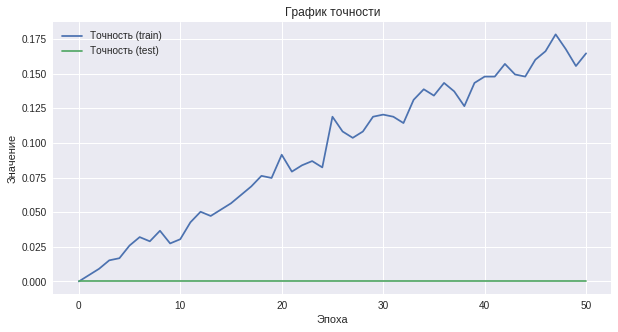

In [43]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [0]:
from pathlib import Path
from os import remove

file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print('Текущий каталог с контрольными точками {Z}'.format(Z=checkpoints_dir.absolute()))
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print('Удаляем файл {}'.format(Z=item))
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [46]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками /content/save_points
Train on 525 samples, validate on 132 samples
Epoch 1/300
525/525 [==============================] - 0s 809us/step - loss: 23.1700 - categorical_accuracy: 0.1867 - val_loss: 18.7443 - val_categorical_accuracy: 0.1970
Epoch 2/300
525/525 [==============================] - 0s 412us/step - loss: 14.9022 - categorical_accuracy: 0.2438 - val_loss: 15.4733 - val_categorical_accuracy: 0.3712
Epoch 3/300
525/525 [==============================] - 0s 385us/step - loss: 13.4533 - categorical_accuracy: 0.4476 - val_loss: 15.6052 - val_categorical_accuracy: 0.4394
Epoch 4/300
525/525 [==============================] - 0s 397us/step - loss: 13.0413 - categorical_accuracy: 0.4876 - val_loss: 15.8192 - val_categorical_accuracy: 0.4848
Epoch 5/300
525/525 [==============================] - 0s 379us/step - loss: 12.7736 - categorical_accuracy: 0.4724 - val_loss: 16.0601 - val_categorical_accuracy: 0.4318
Epoch 6/300
525/

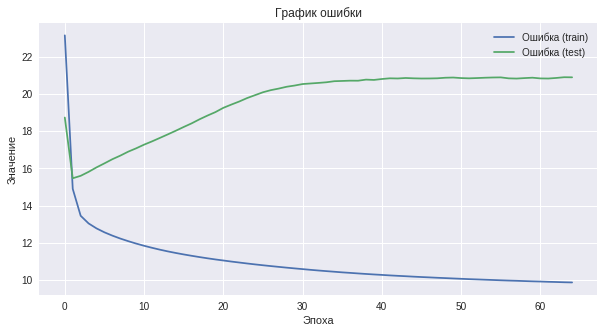

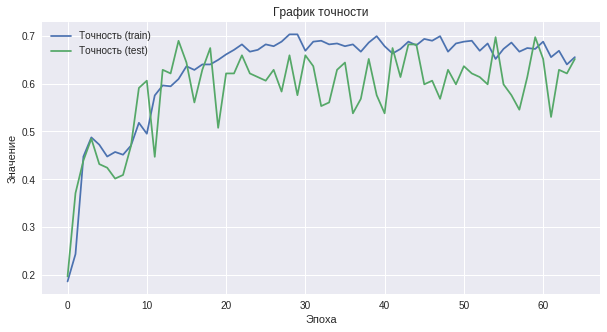

In [47]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);